In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
from tqdm.auto import tqdm
from scipy.stats import pearsonr
from tools.analysis import *

# mpl.use('pgf')
# mpl.rcParams.update({
#     "pgf.texsystem": "pdflatex",  # Use pdflatex for rendering
#     'font.family': 'serif',       # Use serif font family
#     'text.usetex': True,          # Use LaTeX for text rendering
#     'pgf.rcfonts': False,         # Don't setup fonts from rc params
#     'pgf.preamble': r'\usepackage{amsmath,amsfonts,amssymb}\usepackage[T2A,T1]{fontenc}\usepackage[utf8]{inputenc}\usepackage[ukrainian]{babel}',  # Use Ukrainian Cyrillic font
#     'font.size': 10               # Set font size
# })

In [2]:
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, rubberband_baseline_cor

from scipy.signal import savgol_filter, detrend
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

<Axes: >

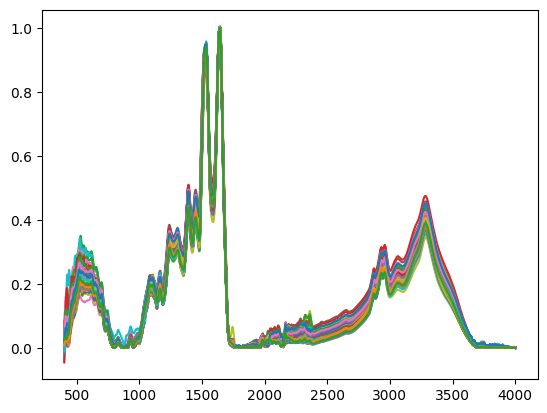

In [3]:
domain = pd.read_csv('data/domain.csv')
df = pd.read_csv('data/dataset.csv')
X = df.drop(columns=['HbA1c', 'years'])
y = df['HbA1c']
X.columns = np.ravel(domain)

X = X.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
X = X.apply(lambda row: row / max(row), axis=1)
X = X.T.apply(lambda col: savgol_filter(col, window_length=50, polyorder=2)).T
#X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)
X.T.plot(legend=False)

In [4]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None, random_state=24)
categories = discretizer.fit_transform(y.to_numpy().reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=categories, random_state=44)

In [5]:
freq = pd.read_csv("data/freq.csv")
freq = freq['0'].to_numpy()

719

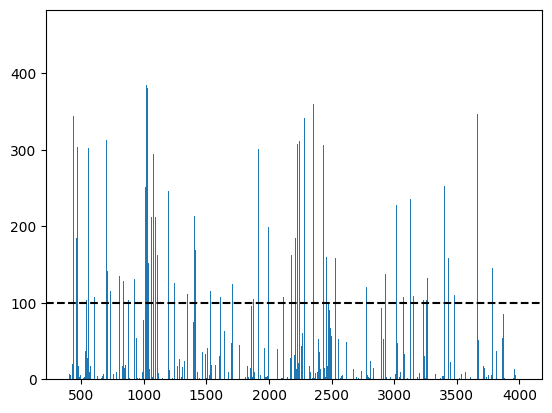

In [6]:
threshold = 100

plt.bar(np.ravel(domain), freq)
plt.axhline(y=threshold, color='k', linestyle='--')
(freq > threshold).sum()

286

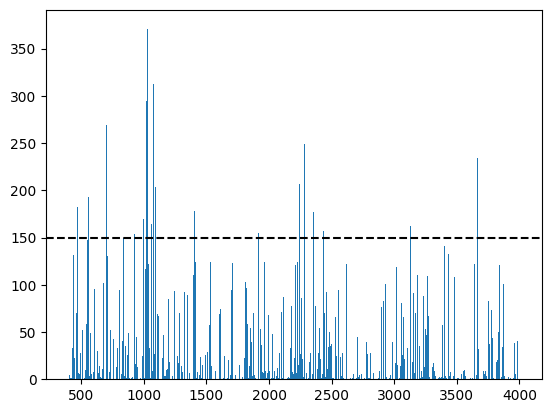

In [7]:
freq_w2 = savgol_filter(freq, window_length=10, polyorder=1)

threshold = 150

plt.bar(np.ravel(domain), freq_w2)
plt.axhline(y=threshold, color='k', linestyle='--')
(freq_w2 > threshold).sum()

In [8]:
idx = np.where(freq_w2 > threshold)[0]

In [9]:
# for threshold in range(10, 101, 10):
#     idx = np.where(freq_w2 > threshold)[0]
#     res = find_number_components(X_train.iloc[:, idx], y_train, cv=5, number_range=(1, 20), returns='values', message=False)
#     print(threshold, res)

┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSE = 1.0068             │
│ R2 = 0.6626               │
│ R = 0.8164                │
│ Number of components = 12 │
└───────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='Sample', ylabel='Residuals'>]], dtype=object))

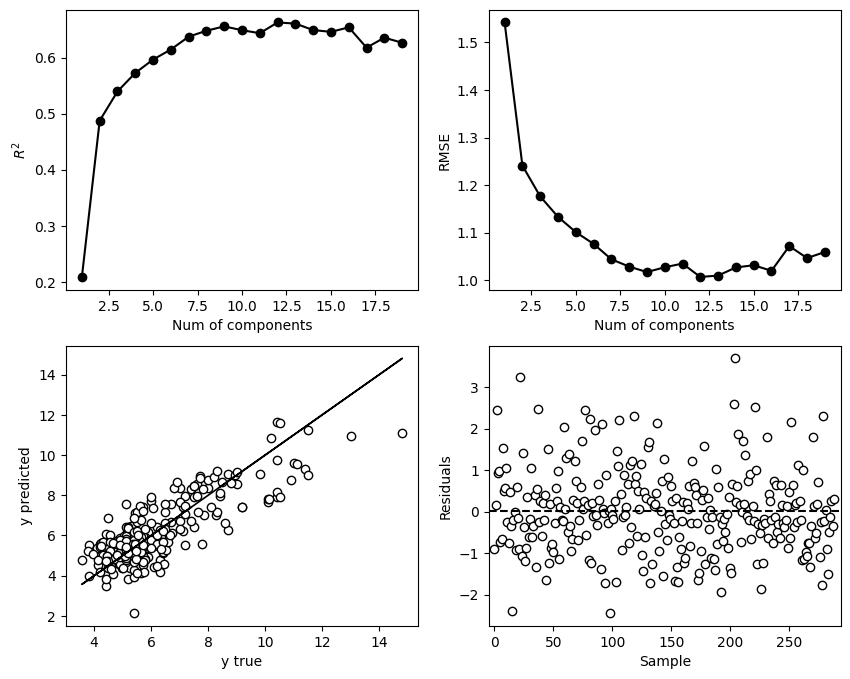

In [10]:
plot_number_components(X_train.iloc[:, idx], y_train, cv=10)

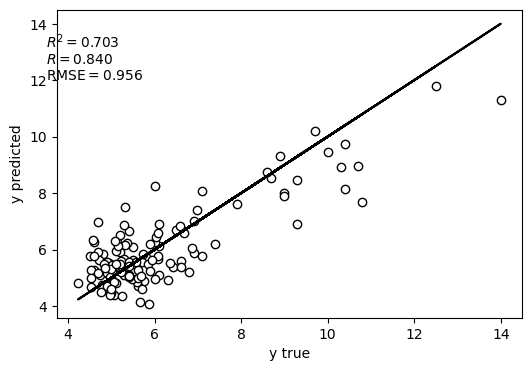

In [11]:
pls = PLSRegression(n_components=7)
pls.fit(X_train.iloc[:, idx], y_train)
y_pred = pls.predict(X_test.iloc[:, idx])
fig, axs = plsr_r2_plot(y_test, y_pred)

Text(0, 0.5, '$t_2$')

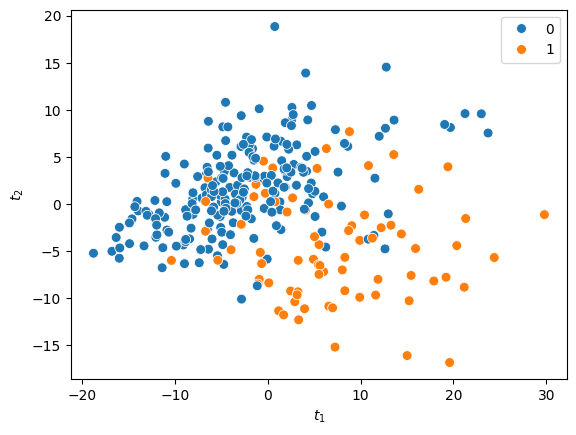

In [12]:
t1 = pls.x_scores_[:, 0]
t2 = pls.x_scores_[:, 1]
db = np.where(y_train >= 6.5, 1, 0)
# db = pd.Series(db)
# db = db.map({1: "Diabetes", 0: "Healthy"})

components = pd.DataFrame({
    "t1": t1,
    "t2": t2,
    "diabetes": db
})

sns.scatterplot(data=components, x=t1, y=t2, hue=db, s=50)
plt.legend(title=None)
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')

In [13]:
class CARS:
    def __init__(self):
        self.weights = []
        self.retain_num = []
        self.retain_ratio = []
        self.r2s = []
        self.rmses = []

    def fit(self, X, y, n_comp, n_rep, X_val=None, y_val=None):
        self.n_samples, self.n_features = X.shape
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        model = PLSRegression(n_components=n_comp)
        model.fit(X_train, y_train)
        
        weights = np.abs(model.coef_[0]) / np.sum(np.abs(model.coef_[0]))
        self.weights.append(weights)
        
        for i in range(1, n_rep + 1):
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            
            pls = PLSRegression(n_components=n_comp)
            pls.fit(X_train, y_train)
        
            a = (self.n_features / 2)**(1 / (n_rep - 1))
            k = np.log(self.n_features / 2) / (n_rep - 1)
            retain_ratio = a * np.exp(-(k * i))
            retain_ratio = 1 if retain_ratio > 0.99 else retain_ratio
            retain_num = int(self.n_features * retain_ratio)
        
            sampled_indices = np.random.choice(np.arange(self.n_features), size=retain_num, replace=False, p=weights)
        
            X_sampled = X_train.iloc[:, sampled_indices]
    
            if len(X_sampled.columns) <= n_comp:
                self.weights = np.array(self.weights)
                self.retain_num = np.array(self.retain_num)
                self.retain_ratio = np.array(self.retain_ratio)
                self.r2s = np.array(self.r2s)
                self.rmses = np.array(self.rmses)
                return 
    
            pls = PLSRegression(n_components=n_comp)
            pls.fit(X_sampled, y_train)
            y_cv = cross_val_predict(pls, X_sampled, y_train, cv=10)
    
    
            reg_coef = np.zeros(self.n_features)
            reg_coef[sampled_indices] = np.abs(pls.coef_[0]) / np.sum(np.abs(pls.coef_[0]))
            unselected_indices = np.setdiff1d(np.arange(self.n_features), sampled_indices)
            reg_coef[unselected_indices] = 0
            weights = reg_coef

            # if X_val is not None:
            #     y_pred_val = pls.predict(X_val.iloc[:, sampled_indices])
            #     print(r2_score(y_val, y_pred_val), end=' ')
            
            self.weights.append(weights)
            self.retain_num.append(retain_num)
            self.retain_ratio.append(retain_ratio)
            self.r2s.append(r2_score(y_train, y_cv))
            self.rmses.append(np.sqrt(mean_squared_error(y_train, y_cv)))
            #print(r2_score(y_train, y_cv))

        self.weights = np.array(self.weights)
        self.retain_num = np.array(self.retain_num)
        self.retain_ratio = np.array(self.retain_ratio)
        self.r2s = np.array(self.r2s)
        self.rmses = np.array(self.rmses)
    
        return

    def get_features(self):
        index = np.argmax(self.r2s)
        print(f"R2: {np.max(self.r2s)}\nRMSE: {np.min(self.rmses)}\nIndex: {index}")        
        return np.where(self.weights[index] > 0)[0]

In [14]:
# domain = pd.read_csv('data/domain.csv')
# df = pd.read_csv('data/dataset.csv')
# X = df.drop(columns=['HbA1c', 'years'])
# y = df['HbA1c']
# X.columns = np.ravel(domain)

# X = X.apply(lambda row: row / max(row), axis=1)
# X = X.T.apply(lambda col: savgol_filter(col, window_length=20, polyorder=2)).T
# #X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)

# discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None, random_state=24)
# categories = discretizer.fit_transform(y.to_numpy().reshape(-1, 1))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=categories, random_state=24)

In [15]:
cars = CARS()
cars.fit(X_train, y_train, n_comp=10, n_rep=200)
idx1 = cars.get_features()

R2: 0.7910243961067566
RMSE: 0.7925942181559184
Index: 90


In [16]:
# %%time

# freq = np.zeros(len(X_train.columns))

# for i in range(100):
#     cars = CARS()
#     cars.fit(X_train, y_train, 10, 100)
#     idx = cars.get_features()
    
#     freq[idx] += 1

# pd.Series(freq).to_csv("data/cars_freq.csv")

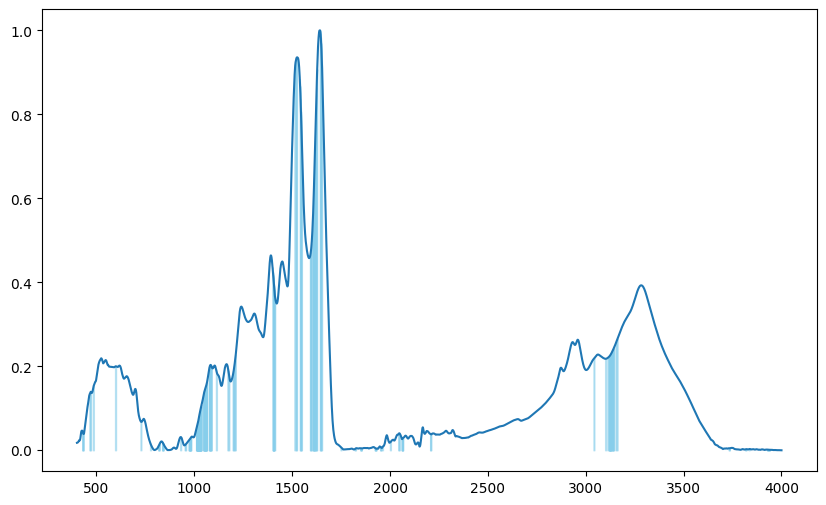

In [17]:
absorbance = X_train.iloc[0]
x_values = np.ravel(domain)
absorbance.index = x_values

plt.figure(figsize=(10, 6))
plt.plot(absorbance)
#plt.ylim([0, 1.3])

for index in idx1:
    plt.fill_between(x_values[max(0, index-5):min(len(x_values), index+6)], 0, absorbance.iloc[max(0, index-5):min(len(x_values), index+6)], color='skyblue', alpha=0.5)

┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSE = 0.8480             │
│ R2 = 0.7607               │
│ R = 0.8732                │
│ Number of components = 11 │
└───────────────────────────┘


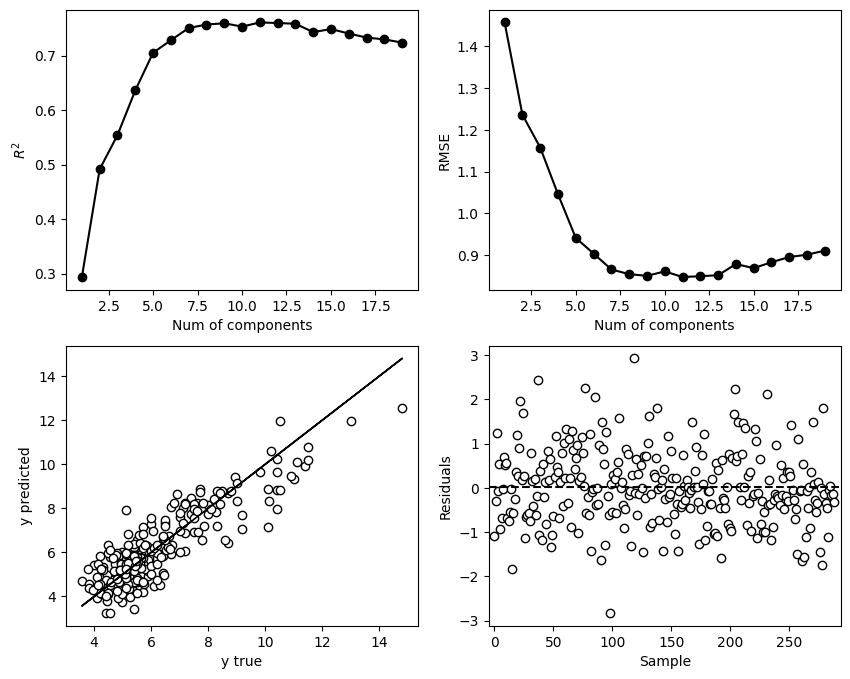

In [18]:
X_cut = X.iloc[:, idx1]
#X_train, X_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.3, stratify=categories, random_state=44) # random state 44
fig, axs = plot_number_components(X_train.iloc[:, idx1], y_train, cv=10, number_range=(1, 20))

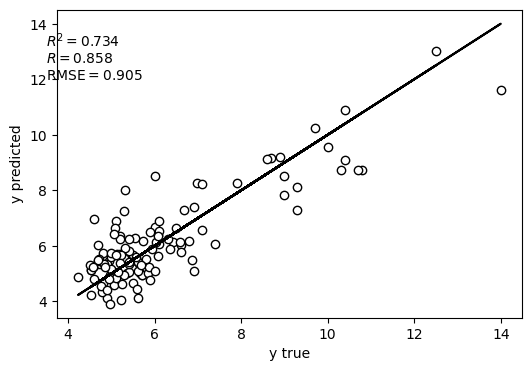

In [32]:
pls = PLSRegression(n_components=8)
pls.fit(X_train.iloc[:, idx1], y_train)
y_pred = pls.predict(X_test.iloc[:, idx1])
fig, axs = plsr_r2_plot(y_test, y_pred)

Text(0, 0.5, '$t_2$')

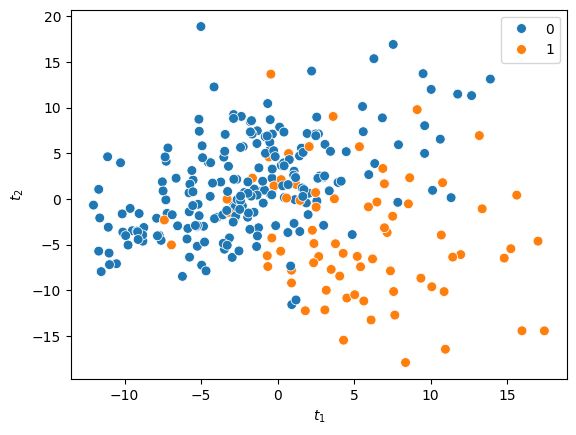

In [20]:
t1 = pls.x_scores_[:, 0]
t2 = pls.x_scores_[:, 1]
db = np.where(y_train >= 6.5, 1, 0)
# db = pd.Series(db)
# db = db.map({1: "Diabetes", 0: "Healthy"})

components = pd.DataFrame({
    "t1": t1,
    "t2": t2,
    "diabetes": db
})

sns.scatterplot(data=components, x=t1, y=t2, hue=db, s=50)
plt.legend(title=None)
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')

In [21]:
np.ravel(domain)[idx]

array([ 469.1073,  469.5894,  470.0715,  470.5536,  471.0358,  471.5179,
        551.0685,  551.5506,  552.0327,  552.5148,  552.9969,  553.4791,
        553.9612,  554.4433,  554.9255,  555.4076,  555.8897,  556.3718,
        556.8539,  557.3361,  557.8182,  558.3003,  558.7825,  700.0449,
        700.5271,  701.0092,  701.4913,  701.9734,  702.4556,  702.9377,
        703.4198,  703.902 ,  704.3841,  704.8662,  834.5577,  835.0399,
        835.522 ,  836.0041,  836.4862,  836.9683,  925.6793,  926.1614,
        926.6435,  927.1256,  927.6078,  928.0899,  928.572 ,  929.0541,
        929.5363,  997.5158,  997.9979,  998.4801,  998.9622,  999.4443,
        999.9265, 1000.409 , 1000.891 , 1001.373 , 1001.855 , 1020.176 ,
       1020.658 , 1021.14  , 1021.622 , 1022.104 , 1022.586 , 1023.068 ,
       1023.551 , 1024.033 , 1024.515 , 1024.997 , 1025.479 , 1025.961 ,
       1026.443 , 1026.925 , 1027.408 , 1027.89  , 1028.372 , 1028.854 ,
       1029.336 , 1029.818 , 1030.3   , 1030.782 , 

In [22]:
len(idx)

286

<BarContainer object of 7468 artists>

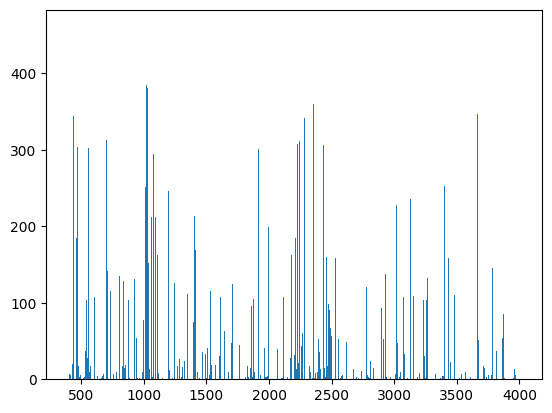

In [23]:
#plt.bar(np.ravel(domain), freq)

(800.0, 1700.0)

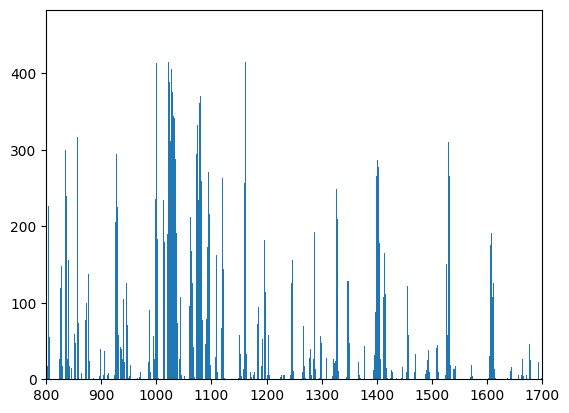

In [24]:
# plt.bar(np.ravel(domain), freq)
# plt.xlim([800, 1700])

(1000.0, 1100.0)

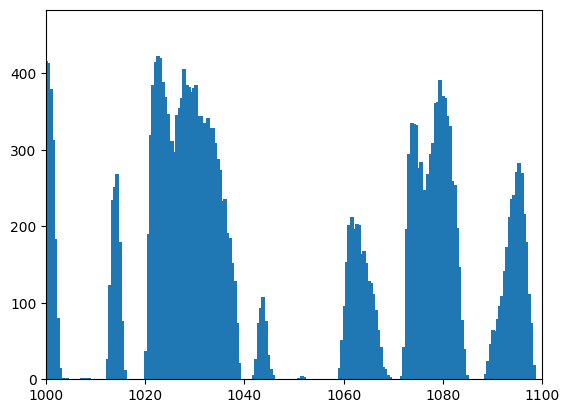

In [25]:
# plt.bar(np.ravel(domain), freq)
# plt.xlim([1000, 1100])

(1350.0, 1450.0)

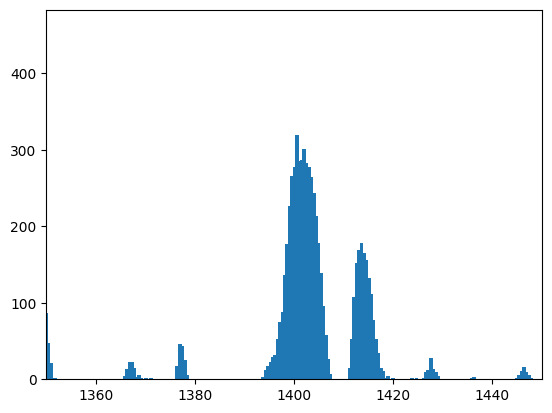

In [26]:
# plt.bar(np.ravel(domain), freq)
# plt.xlim([1350, 1450])

(1600.0, 1700.0)

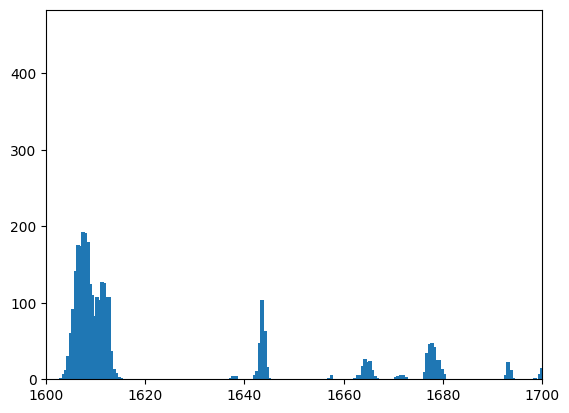

In [27]:
# plt.bar(np.ravel(domain), freq)
# plt.xlim([1600, 1700])

<Axes: >

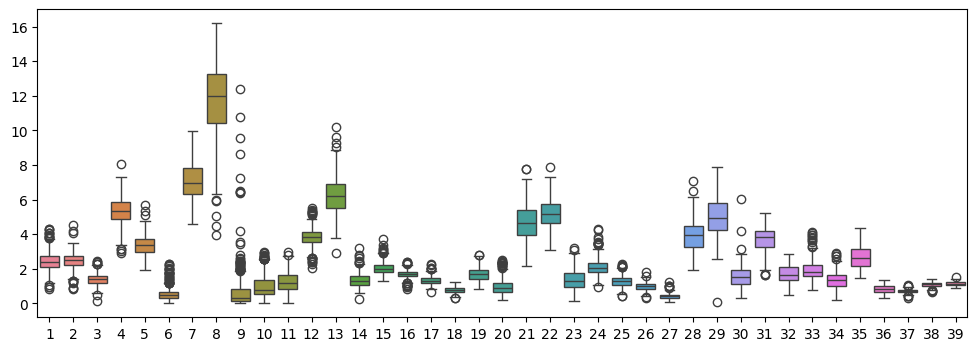

In [28]:
areas = pd.read_csv("voigt/areas.csv")
areas = areas.iloc[:, 1:]
plt.figure(figsize=(12, 4))
sns.boxplot(data=areas.iloc[:, 1:])

In [29]:
df = pd.read_csv("data/dataset.csv")
hba1c = df['HbA1c']

areas_hba1c = areas.copy()
areas_hba1c['HbA1c'] = hba1c
areas_hba1c

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,HbA1c
0,1.269671,2.242090,2.904583,1.181092,5.187289,3.690730,0.409881,6.753196,11.507986,2.193665,...,3.011314,1.009232,2.489226,1.353928,1.949124,1.066166,0.723758,1.141663,1.093992,5.80
1,1.086314,2.659471,1.903250,2.148942,4.799445,3.947502,0.455245,7.882393,11.529394,0.141940,...,4.338387,0.698907,2.308709,1.476173,2.070021,1.059104,0.829419,1.206537,1.210135,5.08
2,1.005208,2.805271,2.616210,1.258152,5.789641,2.841135,0.585467,6.289443,12.909425,1.107982,...,3.525328,1.629940,1.782261,2.092763,1.892019,1.210059,0.516541,1.171776,1.045743,7.50
3,1.187131,2.532238,2.500375,1.216768,5.151551,3.223425,0.680398,6.146676,13.540820,0.104225,...,2.967014,1.938620,2.024022,0.546640,3.480590,0.365566,0.578128,1.185087,1.043786,4.46
4,1.813687,1.700605,2.527093,1.457997,5.700287,3.393913,0.435083,6.257633,15.502322,0.104088,...,3.814704,1.258794,1.295912,1.636335,2.908103,0.683420,0.843156,1.001145,1.231247,5.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,0.672726,3.325152,2.608123,1.167349,5.706275,3.070262,0.533461,6.863058,13.024981,0.212455,...,3.319069,2.386966,2.739491,0.770818,1.978352,0.983382,0.755837,1.008693,1.308068,6.50
409,0.785157,2.472456,2.333371,1.212313,5.488864,2.854444,0.056518,8.979287,7.604872,0.620475,...,4.053257,2.082666,2.859916,1.991641,2.088043,0.604974,0.886635,0.664731,1.201242,NaN
410,1.509007,2.741033,3.007450,0.734060,5.403552,2.636079,0.560256,6.076751,6.448517,10.781962,...,4.118186,1.695207,2.610159,0.411909,2.665331,0.576920,0.807994,0.872485,1.260508,6.10
411,0.860885,2.685204,2.483816,1.245277,5.330087,3.336537,0.455499,5.713687,14.441716,0.087104,...,4.317602,2.332882,1.474381,1.748166,2.742218,0.629612,0.740201,1.093853,1.172293,7.90


┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSE = 1.5540             │
│ R2 = 0.2021               │
│ R = 0.4697                │
│ Number of components = 17 │
└───────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='Sample', ylabel='Residuals'>]], dtype=object))

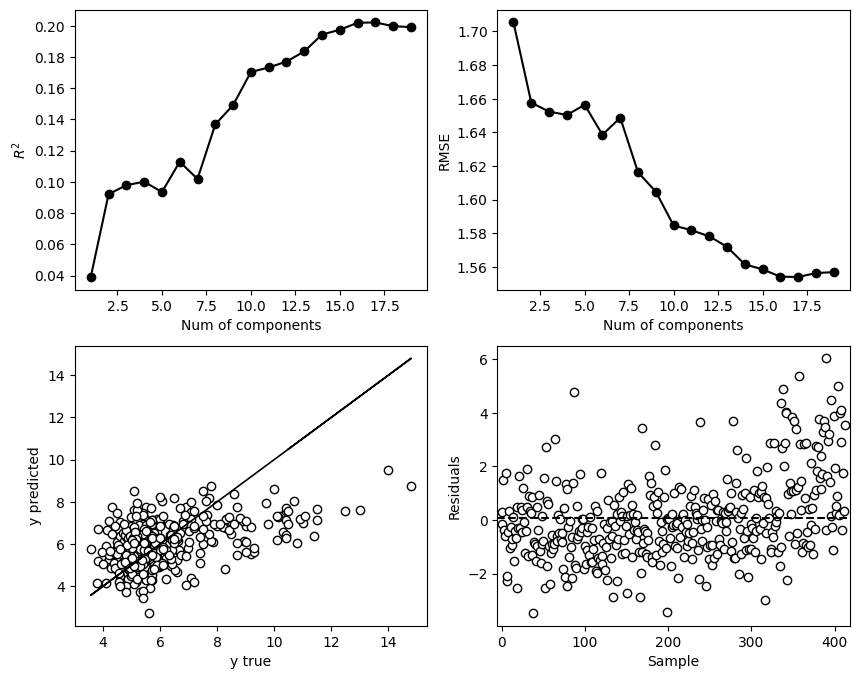

In [31]:
plot_number_components(areas, hba1c, cv=10)

In [33]:
idx

array([ 143,  144,  145,  146,  147,  148,  313,  314,  315,  316,  317,
        318,  319,  320,  321,  322,  323,  324,  325,  326,  327,  328,
        329,  622,  623,  624,  625,  626,  627,  628,  629,  630,  631,
        632,  901,  902,  903,  904,  905,  906, 1090, 1091, 1092, 1093,
       1094, 1095, 1096, 1097, 1098, 1239, 1240, 1241, 1242, 1243, 1244,
       1245, 1246, 1247, 1248, 1286, 1287, 1288, 1289, 1290, 1291, 1292,
       1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303,
       1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314,
       1315, 1316, 1317, 1318, 1319, 1320, 1372, 1373, 1374, 1375, 1376,
       1377, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403,
       1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414,
       1415, 1416, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444,
       1492, 1493, 1494, 1495, 1574, 1575, 1576, 1577, 1578, 1579, 1580,
       1581, 1582, 1923, 1924, 2070, 2071, 2072, 20